# Setup

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
mpl.rc('figure',figsize=(5, 20))
mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16)
mpl.rc('font', size=16)

In [3]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)


import seaborn as sns
import pandas as pd
import json, os, glob, string

from time import time
from skimage import io
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2021-08-06 04:53:50.090328: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-06 04:53:50.090379: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
ann_path = os.path.join('HKR_Dataset_Words_Public', 'ann')
img_path = os.path.join('HKR_Dataset_Words_Public', 'img')

In [5]:
def read_image(path: str, ax: matplotlib.axes._subplots.Axes,
               title: str='', img_path: str=img_path) -> None:

    '''Utility fiunction for printing images from "path"'''

    image = io.imread(os.path.join(img_path, path))
    ax.imshow(image, cmap='gray')
    ax.axis("off")
    title = title if title else path
    ax.set_title(title)


In [6]:
def counts_to_df(df: pd.DataFrame, column: str='description') -> pd.DataFrame:
    
    '''Return dataframe with symbols counts from "column"'''

    counts = pd.DataFrame(df[column].str.split('').explode())
    counts = counts.join(counts[column].value_counts(), on=column, rsuffix='1')
    counts.columns = ['symbols', 'counts']
    counts = counts[~(counts.symbols == '') & ~(counts.symbols == ' ')]  #.drop_duplicates()
    
    return counts

In [7]:
def meta_collect(ann_path: str, result_file: str, sep: str='\t') -> None:
    
    '''collect metadata for all images to "result_file"
    from json files in "ann_path" (execution time: about 5 mins)'''

    start = time()
    with open(result_file, 'w',  encoding='utf-8') as f:
        f.write(sep.join(['width', 'height', 'description',
                           'isModerated', 'moderatedBy', 'predicted']) + '\n')

    
        for file in tqdm(glob.glob(os.path.join(ann_path, '*.json'))):

            with open(file, encoding='utf-8') as js:
                tmp = json.load(js)

            try:
                f.write(sep.join([tmp['name'], str(tmp['size']['width']), str(tmp['size']['height']),
                               tmp['description'], str(tmp['moderation']['isModerated']),
                               tmp['moderation']['moderatedBy'], str(tmp['moderation']['predicted'])]) + '\n')
            except Exception:
                print(tmp['description'])
    print('execution time:', (time() - start), 'secs')

# meta_collect(ann_path, 'metadata.tsv')
df = pd.read_csv('metadata.tsv', sep='\t', index_col=0)

print(df.shape)
df.head()

100%|████████████████████████████████████████████████████████████████████████████| 64943/64943 [02:47<00:00, 387.70it/s]


execution time: 167.8197329044342 secs
(64943, 6)


,width,height,description,isModerated,moderatedBy,predicted
0_0_0,495,64,Шёл человек.,1,Norlist,NaN
0_0_1,494,65,Шёл человек,1,Norlist,NaN
0_0_10,489,73,Шёл человек,1,Norlist,NaN
0_0_11,406,46,Шёл человек.,1,Norlist,NaN
0_0_12,379,76,Шёл человек,1,Norlist,NaN


# EDA with some preprocessing

In [8]:
df

,width,height,description,isModerated,moderatedBy,predicted
0_0_0,495,64,Шёл человек.,1,Norlist,NaN
0_0_1,494,65,Шёл человек,1,Norlist,NaN
0_0_10,489,73,Шёл человек,1,Norlist,NaN
0_0_11,406,46,Шёл человек.,1,Norlist,NaN
0_0_12,379,76,Шёл человек,1,Norlist,NaN
...,...,...,...,...,...,...
9_9_875,543,94,Вид постоялого,1,Norlist,NaN
9_9_877,462,73,Вид постоялого,1,Norlist,NaN
9_9_878,595,83,Вид постоялого,1,Norlist,NaN
9_9_879,532,72,Вид постоялого,1,Norlist,NaN


### Drop useless columns

In [9]:
df[~df.predicted.isna()]

,width,height,description,isModerated,moderatedBy,predicted


In [10]:
df.isModerated.value_counts()

1    64943
Name: isModerated, dtype: int64

In [11]:
df.drop(['predicted', 'isModerated'], axis=1, inplace=True)

### Moderator - useless or not? (need help)

In [12]:
cou = df.moderatedBy.value_counts()
cou

Norlist               59421
Daniyar Borisovich     5522
Name: moderatedBy, dtype: int64

In [13]:
cou[1] / (cou[0] + cou[1]) # ?

0.08502840952835564

### Some random pictures

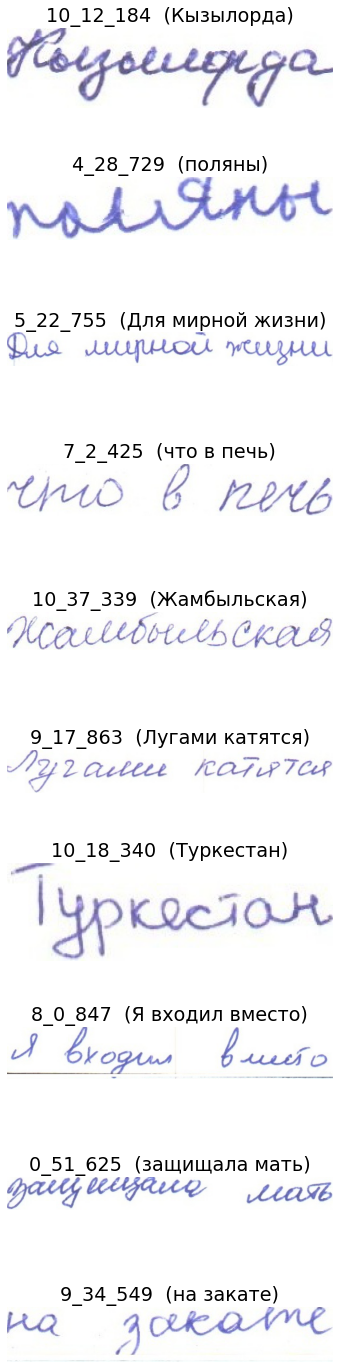

In [14]:
n = 10
img_names = random.choice(df.index, n)
fig, axes = subplots(n, 1)

for img_name, ax in zip(img_names, axes):
    read_image(img_name + '.jpg', ax=ax, title=img_name + f'  ({df.loc[img_name].description})')
tight_layout()

### Dataset symbol counts

,symbols,counts
0_0_0,Ш,1155
0_0_0,ё,372
0_0_0,л,28414
0_0_0,ч,6503
0_0_0,е,38527
...,...,...
9_9_880,я,19107
9_9_880,л,28414
9_9_880,о,52015
9_9_880,г,10149


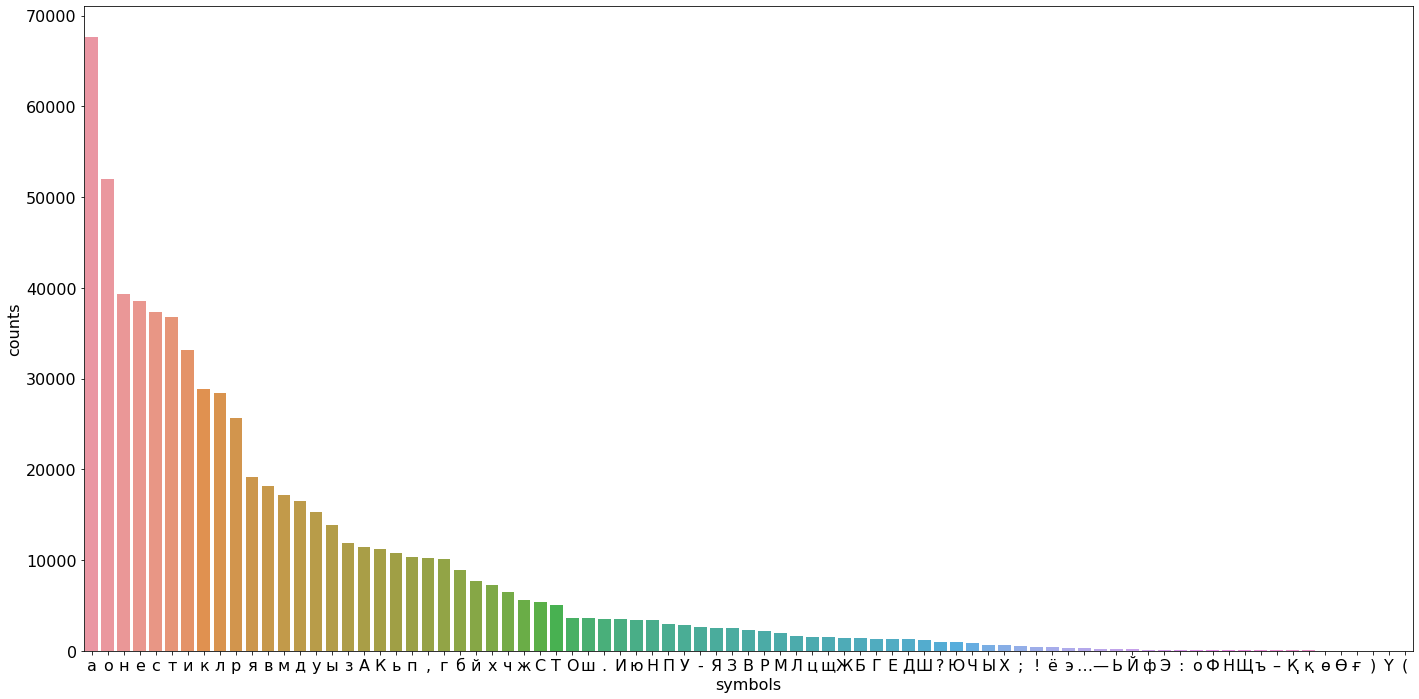

In [15]:
# Creating dataframe with symbol counts with indexes from original df
counts = counts_to_df(df, 'description')

# Barplot with symbol counts in dataset
fig, ax = subplots(figsize=(20, 10))
sns.barplot(data=counts.sort_values('counts', ascending=False), x='symbols', y='counts', ax=ax)

tight_layout()
counts

### Find all non-ordinary symbols for Russian language

In [16]:
# Creating reference alphabet with Russian (lower- and uppercase) and punctuation symbols
alphabet_lower = [chr(ord("а") + i) for i in range(32)] + [chr(ord("а") + 33)] # Last is "ё"
alphabet_upper = [chr(ord("А") + i) for i in range(32)]
punctuation = list(string.punctuation)

alphabet = set(alphabet_lower + alphabet_upper + punctuation)

# Creating alphabet from dataset
counts_dict = counts.set_index('symbols')['counts'].to_dict()

# difference between dataset and reference alphabet
smth_symbols = set(counts_dict) - alphabet 
smth_symbols

{'H', 'o', 'ғ', 'Қ', 'қ', 'Ү', 'Ө', 'ө', '–', '—', '…'}

### Plotting the non-reference symbols 

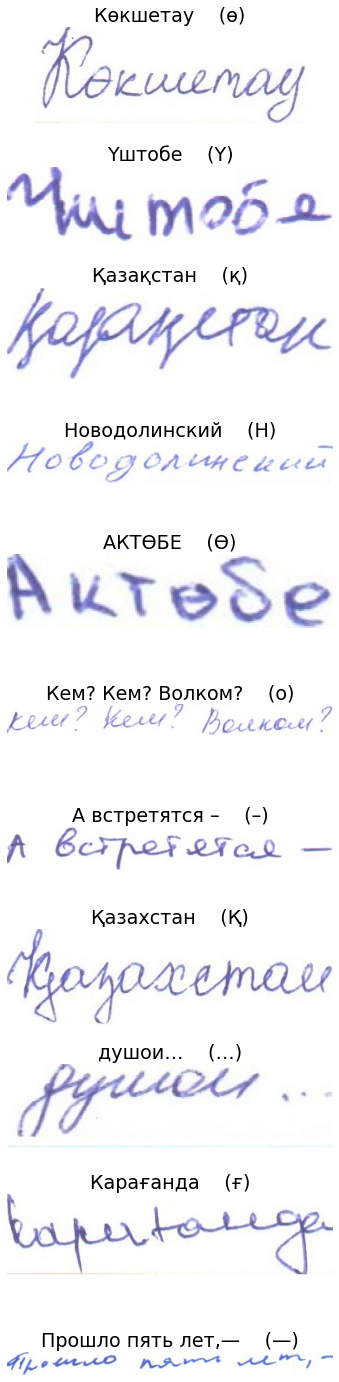

In [17]:
fig, axes = subplots(len(smth_symbols), 1)

for sym, ax in zip(smth_symbols, axes):
    ind = counts[counts.symbols == sym].index[0]
    read_image(ind + '.jpg', ax, df.loc[ind].description + f'    ({sym})')
tight_layout()

### Rows with non-reference symbols

In [18]:
pd.options.display.max_rows = 100
df.loc[counts[counts.symbols.isin(smth_symbols)].index.drop_duplicates()].drop_duplicates('description')

,width,height,description,moderatedBy
0_46_1,530,70,А встретятся –,Norlist
0_46_46,502,81,"А, встретятся –",Norlist
0_9_0,704,66,Кем? Кем? Волкoм?,Norlist
0_9_15,734,43,Кем? Кем? Волкoм,Norlist
0_9_16,682,65,кем? Кем? Волкoв?,Daniyar Borisovich
0_9_28_,869,59,Кем? Кем? волкoм?,Daniyar Borisovich
0_9_626,712,76,Кем? Чем? Волкoм?,Norlist
10_0_107,377,112,Қазахстан,Norlist
10_0_126,303,85,Қазақстан,Norlist
10_10_123,423,106,Карағанда,Norlist


### Some Russian symbols are in latin spelling and some punctuation symbols are not in unicode format, so rework a part of them

In [19]:
df.description = df.description.str.replace('o', 'о').str.replace('H', 'Н')
df.description = df.description.str.replace('–', '-').str.replace('—', '-').str.replace('…', '...')

### The remaining non-Russian and non-punctuation symbols

In [20]:
counts = counts_to_df(df, 'description')

counts_dict = counts.set_index('symbols')['counts'].to_dict()
kazakh_symbols = set(counts_dict) - alphabet
kazakh_symbols

{'ғ', 'Қ', 'қ', 'Ү', 'Ө', 'ө'}

### Drop remaining non-reference symbols

In [21]:
print("rows to drop:", df.loc[counts[counts.symbols.isin(kazakh_symbols)].index.drop_duplicates()].shape[0])
df = df.drop(counts[counts.symbols.isin(kazakh_symbols)].index.drop_duplicates(), axis=0)
df

rows to drop: 98


,width,height,description,moderatedBy
0_0_0,495,64,Шёл человек.,Norlist
0_0_1,494,65,Шёл человек,Norlist
0_0_10,489,73,Шёл человек,Norlist
0_0_11,406,46,Шёл человек.,Norlist
0_0_12,379,76,Шёл человек,Norlist
...,...,...,...,...
9_9_875,543,94,Вид постоялого,Norlist
9_9_877,462,73,Вид постоялого,Norlist
9_9_878,595,83,Вид постоялого,Norlist
9_9_879,532,72,Вид постоялого,Norlist


### Сomparison between the frequency of letters in the Russian alphabet ([ref link](https://ru.wikipedia.org/wiki/%D0%A7%D0%B0%D1%81%D1%82%D0%BE%D1%82%D0%BD%D0%BE%D1%81%D1%82%D1%8C)) and in the dataset

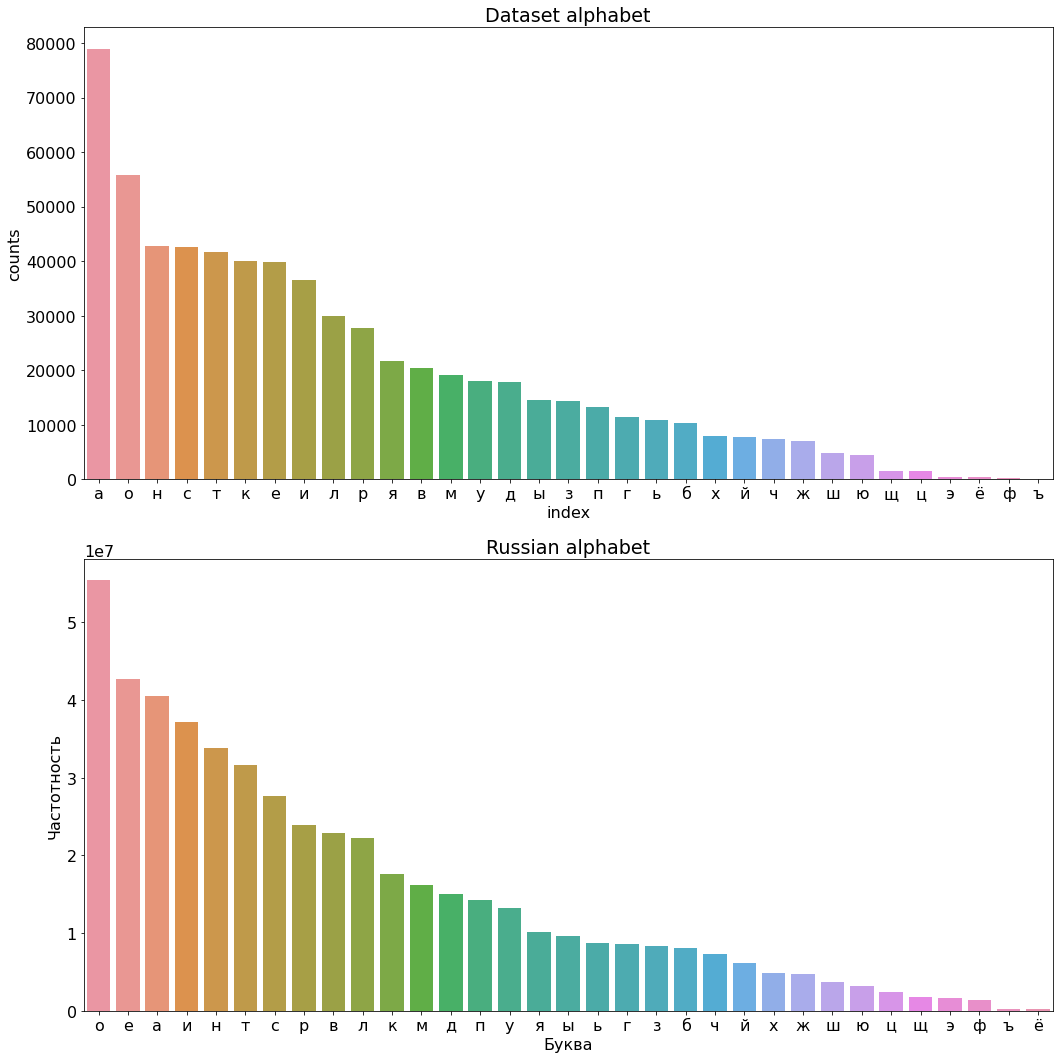

In [22]:
fig, axes = subplots(2, 1, figsize=(15, 15))

tmp = counts_to_df(df)
tmp = tmp[~tmp.symbols.isin(punctuation)].drop_duplicates('symbols')

dictir = {}
for i, j in tmp.iterrows():
    sym, cou = j
    dictir[sym.lower()] = dictir.get(sym.lower(), 0) + cou
tmp = pd.DataFrame(dictir, index=['counts']
                  ).T.reset_index().sort_values('counts', ascending=False)

sns.barplot(data=tmp, x='index', y='counts', ax=axes[0])
axes[0].set_title('Dataset alphabet')

ls = pd.read_csv('alphabet.tsv', sep='\t', 
                 index_col=1).sort_values('Частотность', ascending=False)
sns.barplot(data=ls, x='Буква', y='Частотность', ax=axes[1])
axes[1].set_title('Russian alphabet')
tight_layout()

### Label counts

In [23]:
df.description.value_counts()

Актау              484
Карагандинская     476
Казахстан          474
Шымкент            473
Кокшетау           469
                  ... 
И по изрытму         1
И по ирытому         1
Лангер               1
Где выл пожар-       1
Вид подстоялого      1
Name: description, Length: 2781, dtype: int64

### Pictures sizes description

In [24]:
print(f"width: max = {df.width.max()}, min = {df.width.min()}, mean = {df.width.mean()}")
print(f"height: max = {df.height.max()}, min = {df.height.min()}, mean = {df.height.mean()}\n")

mheight = df.height.value_counts().sort_values(ascending=False)
mwidth = df.width.value_counts().sort_values(ascending=False)

print(f'most common widths (of {mwidth.shape[0]} size):\nwidth\tcount\n{mwidth.head(10)}\nand their mean = {mwidth.head(10).index.to_series().mean()}\n')
print(f'most common heights (of {mheight.shape[0]} size):\nheight\tcount\n{mheight.head(10)}\nand their mean = {mheight.head(10).index.to_series().mean()}')

width: max = 1697, min = 44, mean = 443.46174724342666
height: max = 150, min = 14, mean = 75.69303724265556

most common widths (of 987 size):
width	count
349    166
307    164
310    162
363    157
330    157
358    153
312    151
365    151
317    150
442    148
Name: width, dtype: int64
and their mean = 345.3

most common heights (of 131 size):
height	count
75    1524
71    1507
72    1505
74    1498
73    1495
79    1470
70    1451
68    1444
76    1439
78    1414
Name: height, dtype: int64
and their mean = 73.6


### Most common size values pictures

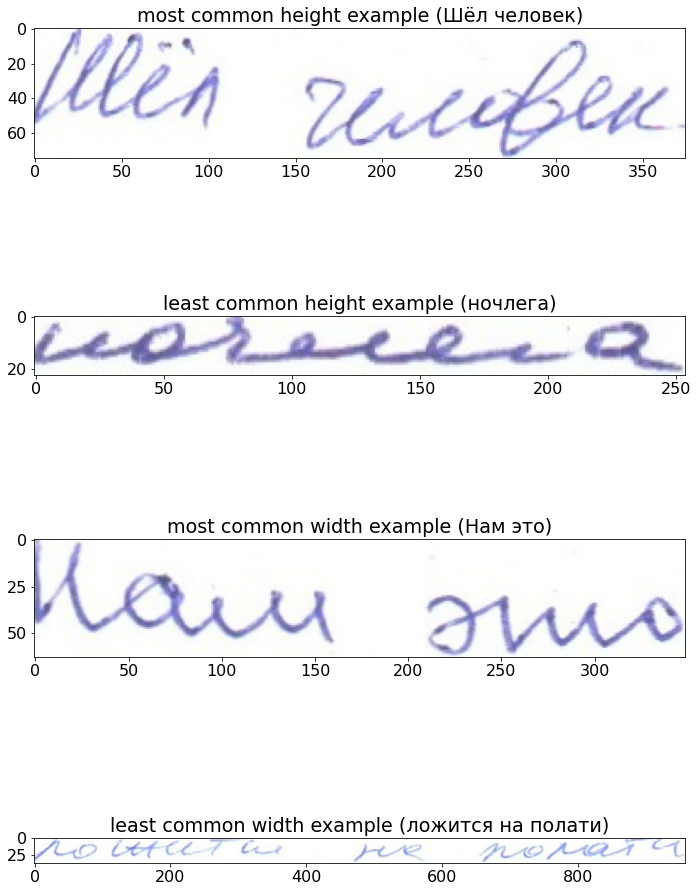

In [25]:
fig, axes = subplots(4, 1, figsize=(10, 15))

df_list = [df[df.height == mheight.index[0]],
           df[df.height == mheight.index[-1]],
           df[df.width == mwidth.index[0]],
           df[df.width == mwidth.index[-1]]]

titles = ['most common height example',
          'least common height example',
          'most common width example',
          'least common width example']

for tmp, title, ax in zip(df_list, titles, axes):
    read_image(tmp.index[0] + '.jpg', ax, title=title + f' ({tmp.description[0]})')
    ax.axis('on')

tight_layout()

### Extreme size values pictures

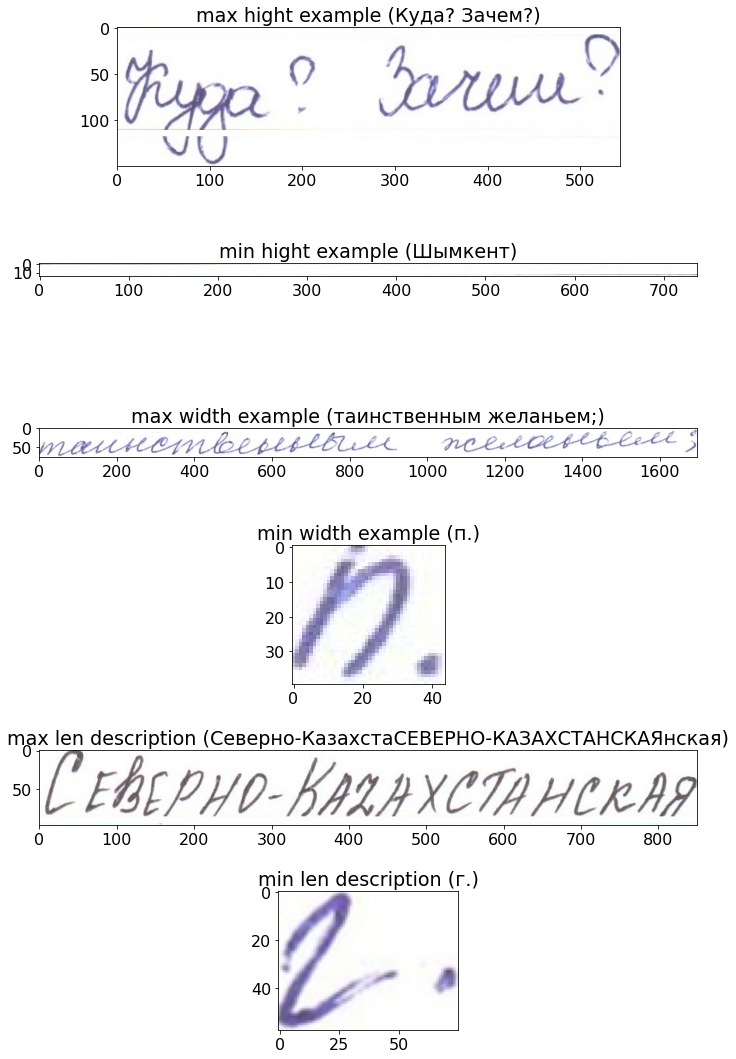

In [26]:
fig, axes = subplots(6, 1, figsize=(10, 15))

df_list = [df[df.height == df.height.max()],
           df[df.height == df.height.min()],
           df[df.width == df.width.max()],
           df[df.width == df.width.min()],
           df[df.description.apply(len) == df.description.apply(len).max()],
           df[df.description.apply(len) == df.description.apply(len).min()]]

titles = ['max hight example',
          'min hight example',
          'max width example',
          'min width example',
          'max len description',
          'min len description']

for tmp, title, ax in zip(df_list, titles, axes):
    read_image(tmp.index[0] + '.jpg', ax, title=title + f' ({tmp.description[0]})')
    ax.axis('on')

tight_layout()

# Train test val split

### Get utility dataframe with rows as picture names and columns as all symbols that presented in dataset.

In [27]:
# There is 1.0 in cell if there is this symbol in this picture otherwise 0 
counts = counts_to_df(df, 'description')
counts.counts = 1
splitter = counts.reset_index().drop_duplicates().pivot(index='index', columns='symbols').fillna(0)
splitter

counts                                               ...            \
symbols      !    (    )    ,    -    .    :    ;    ?    А  ...    ч    ш   
index                                                        ...             
0_0_0      0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  1.0  0.0   
0_0_1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0   
0_0_10     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0   
0_0_11     0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  1.0  0.0   
0_0_12     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0   
...        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
9_9_875    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
9_9_877    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
9_9_878    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
9_9_879    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
9_9_880    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

                                                 
symbols    щ    ъ    ы    ь    э    ю    я    ё  
index                                            
0_0_0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
0_0_1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
0_0_10   0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
0_0_11   0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
0_0_12   0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
...      ...  ...  ...  ...  ...  ...  ...  ...  
9_9_875  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
9_9_877  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
9_9_878  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
9_9_879  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
9_9_880  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  

[64845 rows x 72 columns]

### split into three dataframes (train 85%, test 10%, val 5%)

Sets differences between presented symbols in train, test and val data

train_counts - test_counts:    {'(', ')'}
train_counts - val_counts:    {'(', ')'}
test_counts - train_counts:    set()
test_counts - val_counts:    set()
val_counts - train_counts:    set()
val_counts - test_counts:    set()


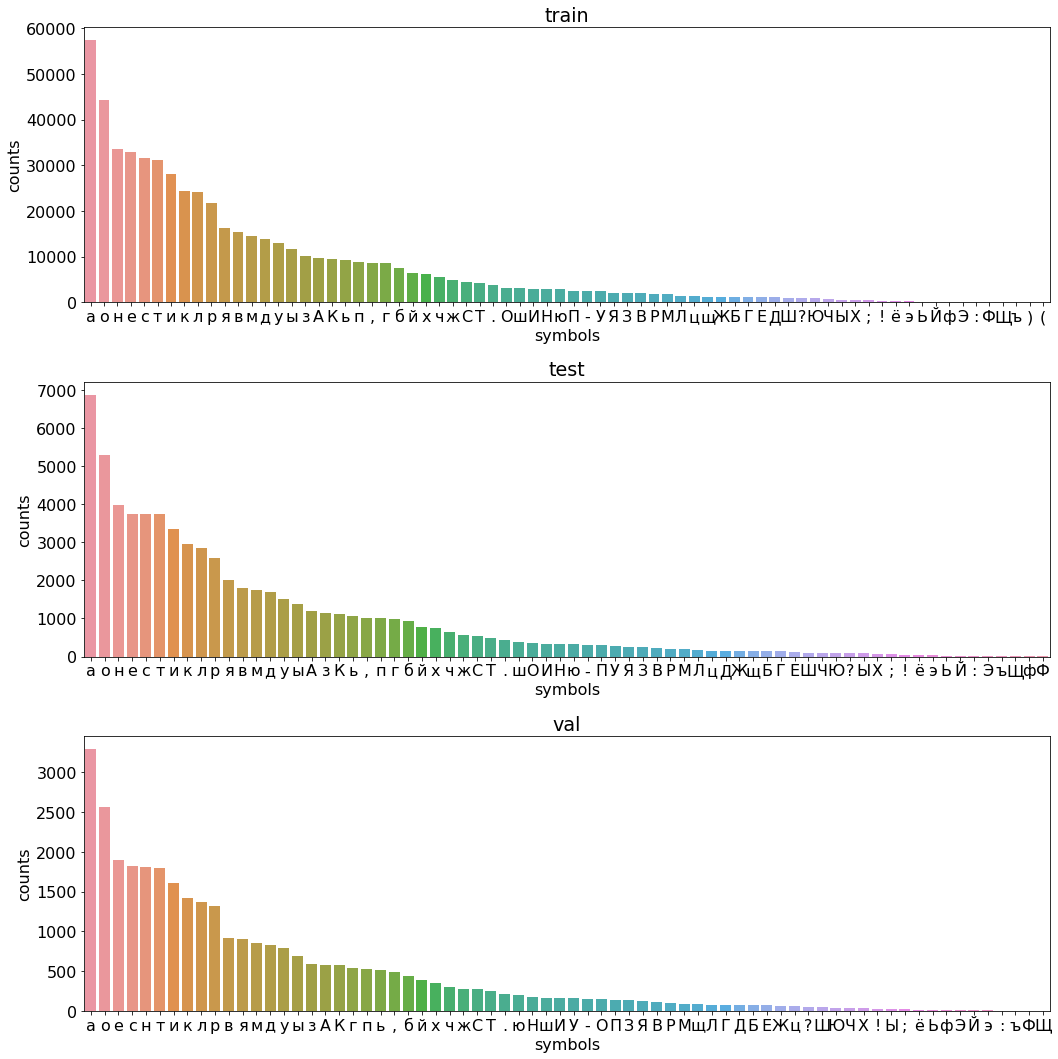

In [28]:
# treat splitter df as multilabel class signature, so we can easy split original df to train and test
train, test, _, ls = train_test_split(df, splitter, shuffle=True,
                            test_size=0.15, random_state=12)

# And then split test to final test and val dfs
test, val, _, _ = train_test_split(test, ls, shuffle=True,
                            test_size=0.33, random_state=17)

train_counts = counts_to_df(train, 'description')
test_counts = counts_to_df(test, 'description')
val_counts = counts_to_df(val, 'description')

print('Sets differences between presented symbols in train, test and val data\n')

print('train_counts - test_counts:   ', set(train_counts.symbols) - set(test_counts.symbols))
print('train_counts - val_counts:   ', set(train_counts.symbols) - set(val_counts.symbols))

print('test_counts - train_counts:   ', set(test_counts.symbols) - set(train_counts.symbols))
print('test_counts - val_counts:   ', set(test_counts.symbols) - set(val_counts.symbols))

print('val_counts - train_counts:   ', set(val_counts.symbols) - set(train_counts.symbols))
print('val_counts - test_counts:   ', set(val_counts.symbols) - set(test_counts.symbols))

# Plot frequencies of symbols in three new dataframes
fig, axes = subplots(3, 1, figsize=(15, 15))

for tmp, ax, name in zip((train_counts, test_counts, val_counts), axes, ['train', 'test', 'val']):
    sns.barplot(data=tmp.sort_values('counts', ascending=False),
                x='symbols', y='counts', ax=ax)
    ax.set_title(name)
tight_layout()

### As we see, all symbols, except "(" and ")" (they occur in dataset only 2 and 1 times respectively), are presented in all three dataframes and frequencies of symbols are very close too. Is it good or not?

# Making tf Dataset

### Constants

In [29]:
batch_size = 16
img_height, img_width, max_length = df.height.max(), df.width.max(), df.description.apply(len).max()
img_height, img_width, max_length

(150, 1697, 42)

### Creating mappers

In [30]:
# Mapping characters to integers
counts = counts_to_df(df)
counts = counts[~counts.isin(['', ' '])].symbols.unique().tolist() + [' ', '#']
vocab = pd.Series(counts).apply(lambda x: x.encode('utf8'))

char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=vocab,
    mask_token=None,
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True,
)

blank_index = char_to_num(tf.strings.unicode_split('#', input_encoding="UTF-8")).numpy()[0]
blank_index  # For oov symbols

2021-08-06 04:26:55.724669: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-06 04:26:55.724842: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-06 04:26:55.725063: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (82b1e98eb348): /proc/driver/nvidia/version does not exist
2021-08-06 04:26:55.726071: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


74

### Functions for tf datasets

In [31]:
def encode_single_sample(img_path, label):
    
    """Function for processing one image from tf dataset"""
    
    # 1. Read 
    img = tf.io.read_file(img_path)
    
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    # 4. Resize to the desired size
    img = 1 - img
    img = tf.image.resize_with_crop_or_pad(img, np.int32(img_height), np.int32(img_width))
    img = 1 - img

    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    label = tf.pad(label, [[0, max_length-len(label)]], constant_values=blank_index)
    
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [32]:
def get_dataset(samples: pd.DataFrame, batch_size=batch_size, 
                shuffle_buffer:int=1024, prefetch:int=tf.data.experimental.AUTOTUNE) -> tf.data.Dataset:
    
    """Function for creating tf dataset"""
    
    dataset = tf.data.Dataset.from_tensor_slices(
        (samples.index.to_series().apply(lambda x: os.path.join(img_path, x) + '.jpg').tolist(),
         samples.description.tolist())
    )
    
    dataset = (
        dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
        )
        .batch(batch_size)
        .prefetch(prefetch)
    )
    
    return dataset

In [33]:
def show_batch(batch, batch_size):
    
    """Utility function for imshow batch"""

    _, ax = plt.subplots(batch_size, 1, figsize=(10, batch_size * 2))
    images = batch['image']
    labels = batch['label']
    for i in range(batch_size):
        img = (images[i] * 255).numpy().astype('uint8')
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode('utf-8').replace('#', '')
    
        ax[i].imshow(img[i:, :, 0].T, cmap='gray')
        ax[i].set_title(label)
        
    plt.show()

### One batch from tf dataset

2021-08-06 04:26:56.620971: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-06 04:26:56.625378: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2400005000 Hz


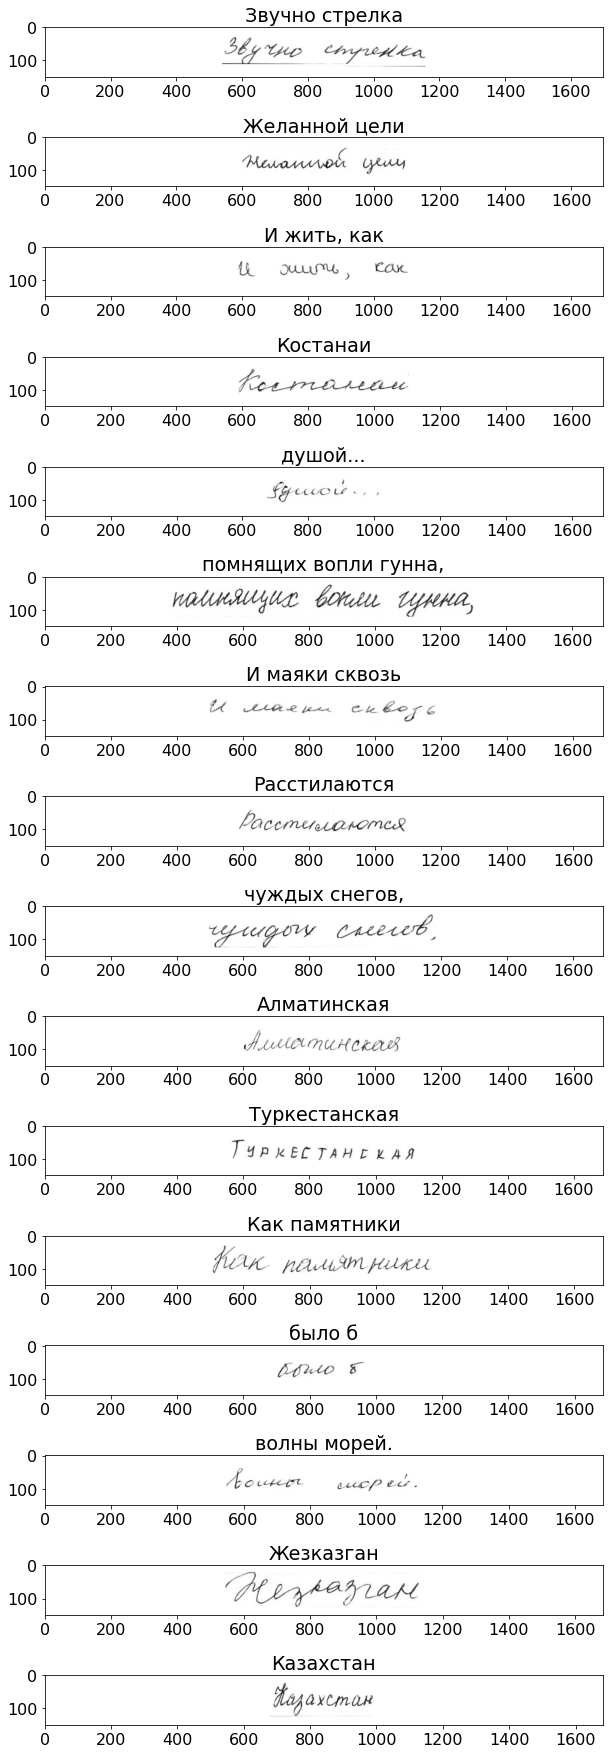

In [34]:
ind = df.index.tolist()
random.shuffle(ind)
ls = get_dataset(df.loc[ind])
for batch in ls.take(1):
    show_batch(batch, batch_size=batch_size)

# Data augmentation

In [65]:
import cv2
import imgaug as ia
import imgaug.augmenters as iaa
import imageio
import numpy as np

paths = df.index.to_series().apply(lambda x: os.path.join(img_path, x) + '.jpg')

aug_1 = os.path.join(img_path, 'aug_1')

if not os.path.exists(aug_1):
    os.mkdir(aug_1)
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)}, # translate by -20 to +20 percent (per axis)
            rotate=(-5, 5), # rotate by -45 to +45 degrees
            shear=(-3, 3), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
#             mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
#                 sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 1.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 0.5), lightness=(0.75, 1.25)), # sharpen images
                iaa.Emboss(alpha=(0, 0.5), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 0.6)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 0.6), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.2), # add gaussian noise to images
                iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.LinearContrast((0.5, 2.0))
                    )
                ]),
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                iaa.Grayscale(alpha=(0.0, 1.0)),
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=True
)

for path in tqdm(paths):
    img = imageio.imread(path)
    image = [np.copy(img) for _ in range(30)]

    ls = seq(images=image)
    
    print(len(ls))
    for i in range(30):
        _, name = os.path.split(path)
        name = os.path.join(aug_1, f'{i}_aug_' + name)
        cv2.imwrite(name, ls[i])
    break

  0%|                                                                                         | 0/64845 [00:00<?, ?it/s]

30
